#2 Run
This file takes in the file written as a .csv from naive.ipynb. The output is used by compare.ipynb

In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import numpy as np
#from arch import arch_model
from scipy.optimize import brentq, newton
from scipy.stats import norm
import scipy.stats as si
from multiprocessing import Pool
from numba import njit


In [2]:
def read_file(file):
    """Read a single file and return a dataframe"""
    return pd.read_csv(file, skipinitialspace=True)

In [3]:
garch = False
rolling_avg = False
implied_vol = False
test_pq = False
iv_surface = True

In [4]:
if implied_vol or iv_surface:
    '''file = '../data/processed_data/2010-2023_NSS_filtered_with_IV.csv'
    df_IV = pd.read_csv(file, skipinitialspace=True)
    df_IV = df_IV[df_IV["Quote_date"] >= "2014-11-01"]
    print("Length of df_IV", len(df_IV))'''
    file = '../data/processed_data/2010-2023_NSS_filtered_vF.csv'
    df = pd.read_csv(file, skipinitialspace=True)
    df = df[df["Quote_date"] >= "2014-11-01"]
    print("Length of df", len(df))
else:
    file = '../data/processed_data/2010-2023_NSS_filtered_vF.csv'
    df = pd.read_csv(file, skipinitialspace=True)
    df = df[df["Quote_date"] >= "2014-11-01"]
    print("Length of df", len(df))

df.info()
print(df.head(3))


Length of df 10654942
<class 'pandas.core.frame.DataFrame'>
Index: 10654942 entries, 1402701 to 12057642
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Quote_date       object 
 2   Price            float64
 3   Underlying_last  float64
 4   Strike           float64
 5   TTM              float64
 6   R                float64
dtypes: float64(5), int64(1), object(1)
memory usage: 650.3+ MB
         Unnamed: 0  Quote_date    Price  Underlying_last  Strike       TTM   
1402701     1682400  2014-11-03  991.000          2017.48  1025.0  0.010959  \
1402702     1682401  2014-11-03  966.000          2017.48  1050.0  0.010959   
1402703     1682402  2014-11-03  941.005          2017.48  1075.0  0.010959   

              R  
1402701  0.0003  
1402702  0.0003  
1402703  0.0003  


# Volatility

### GARCH

In [26]:
if test_pq:
    # Assuming your dataframe is named `df`
    df_unique_dates = df[['Quote_date', 'Underlying_last']].drop_duplicates()

    df_unique_dates['log_returns'] = np.log(df_unique_dates['Underlying_last']) - np.log(df_unique_dates['Underlying_last'].shift(1))
    df_unique_dates = df_unique_dates[['Quote_date', 'log_returns']].dropna()

    # Define a function to fit GARCH models and return AIC and BIC
    def fit_garch_aic_bic(log_returns, p, q):
        model = arch_model(log_returns, vol='Garch', p=p, q=q, dist='Normal')
        results = model.fit(disp='off')
        return results.aic, results.bic

    # Test GARCH models with different p and q values
    pq_values = [(1, 1), (1, 2), (2, 1), (2, 2), (1, 3), (3, 1), (2, 3), (3, 2), (3, 3), (4, 1), (1, 4), (4, 2), (2, 4), (4, 4)]

    aic_bic_values = [fit_garch_aic_bic(df_unique_dates['log_returns'], p, q) for p, q in pq_values]
    aic_values, bic_values = zip(*aic_bic_values)

    # Find the best p and q values based on AIC and BIC
    best_pq_aic = pq_values[np.argmin(aic_values)]
    best_pq_bic = pq_values[np.argmin(bic_values)]
    print(f"Best GARCH model based on AIC: GARCH({best_pq_aic[0]},{best_pq_aic[1]})")
    print(f"Best GARCH model based on BIC: GARCH({best_pq_bic[0]},{best_pq_bic[1]})")


In [27]:
if garch:
    df_unique_dates = df[['Quote_date', 'Underlying_last']].drop_duplicates()

    df_unique_dates['log_returns'] = np.log(df_unique_dates['Underlying_last']) - np.log(df_unique_dates['Underlying_last'].shift(1))
    df_unique_dates = df_unique_dates[['Quote_date', 'log_returns']].dropna()

    # Define GARCH(1,1) model
    model = arch_model(df_unique_dates['log_returns'], vol='Garch', p=1, q=1, dist='Normal')

    # Fit the model
    results = model.fit(update_freq=5)

    # Predict the volatility (annualized)
    df_unique_dates['predicted_volatility'] =  results.conditional_volatility * np.sqrt(252)

    # Merge the predicted volatility with the original dataframe
    df = df.merge(df_unique_dates[['Quote_date', 'predicted_volatility']], on='Quote_date', how='left')

    df = df[df["Quote_date"] >= "2015-01-01"]
    
    # Drop rows with NaN values
    df = df.dropna()

### Rolling average

In [28]:
if rolling_avg:    
    # Add volatility column with 30 day rolling standard deviation of Underlying_last

    # New dataframe without duplicate Quote_dates
    df2 = df.drop_duplicates(subset=['Quote_date'])

    # Calculate volatility
    df2['rolling_volatility'] = np.log(df2["Underlying_last"] / df2["Underlying_last"].shift()).rolling(30).std()*(252**0.5)

    # Matching volatility in df2 to df
    df['rolling_volatility'] = df['Quote_date'].map(df2.set_index('Quote_date')['rolling_volatility'])

    df = df[df["Quote_date"] >= "2015-01-01"]

    # Drop rows with NaN values
    df = df.dropna()

/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_58914/224188184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['rolling_volatility'] = np.log(df2["Underlying_last"] / df2["Underlying_last"].shift()).rolling(30).std()*(252**0.5)


### Implied vol

In [29]:
# Black-Scholes formula for call options
def bs_call(S, K, T, r, vol):
    eps = 1e-8
    d1 = np.divide((np.log(S/K) + (r + 0.5*vol**2)*T), (vol*np.sqrt(T) + eps))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

In [30]:
if implied_vol:    
    # Calculate the average implied volatility for each date
    avg_implied_vol_df = df_IV.groupby(
        'Quote_date')['IV'].median().reset_index()

    # Add a new column with the average implied volatility shifted by one row
    avg_implied_vol_df['avg_implied_vol_t-1'] = avg_implied_vol_df['IV'].shift(1)

    # Merge the avg_implied_vol_df DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_df[[
        'Quote_date', 'avg_implied_vol_t-1']], on='Quote_date', how='left')

    # Drop rows with NaN values
    df = df.dropna()


## IV Surface

In [5]:
df = df[df["Quote_date"] >= "2014-12-01"]
df = df[df["Quote_date"] <= "2015-01-31"]

print(len(df))

df2 = df[df['Quote_date'] >= '2015-01-01']
df2 = df2[df2['Quote_date'] <= '2015-01-31']

print(len(df2))

118153
56797


In [6]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call

def implied_vol(S, K, T, r, market_price):
    try:
        implied_vol = newton(lambda x: black_scholes_call(S, K, T, r, x) - market_price, 0.5)
    except (ValueError, RuntimeError):
        return None
    return implied_vol

if iv_surface:
    df['Implied_Vol'] = df.apply(
        lambda row: implied_vol(row['Underlying_last'], row['Strike'], row['TTM'], row['R'], row['Price']),
        axis=1
    )
    df.to_csv('../data/processed_data/2014-2023_NSS_filtered_vF_with_IV.cs', index=False)

In [7]:
df.info()
# Print df with Implied_Vol not NaN sorted by strike
#print(df[df['Implied_Vol'].notna()].sort_values(by=['Implied_Vol']))
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 118153 entries, 1456800 to 1574952
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       118153 non-null  int64  
 1   Quote_date       118153 non-null  object 
 2   Price            118153 non-null  float64
 3   Underlying_last  118153 non-null  float64
 4   Strike           118153 non-null  float64
 5   TTM              118153 non-null  float64
 6   R                118153 non-null  float64
 7   Implied_Vol      76296 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.1+ MB
         Unnamed: 0  Quote_date     Price  Underlying_last  Strike       TTM   
1456800     1742077  2014-12-01  1004.300          2053.83  1050.0  0.010959  \
1456801     1742078  2014-12-01   979.305          2053.83  1075.0  0.010959   
1456802     1742079  2014-12-01   954.300          2053.83  1100.0  0.010959   
1456803     1742080  2014-12-01   92

In [10]:
df_read = df.copy()

In [13]:
df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118153 entries, 0 to 118152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        118153 non-null  int64  
 1   Quote_date        118153 non-null  object 
 2   Price             118153 non-null  float64
 3   Underlying_last   118153 non-null  float64
 4   Strike            118153 non-null  float64
 5   TTM               118153 non-null  float64
 6   R                 118153 non-null  float64
 7   Implied_Vol       76296 non-null   float64
 8   Moneyness         118153 non-null  float64
 9   moneyness_bucket  118153 non-null  int64  
 10  ttm_bucket        118153 non-null  int64  
 11  implied_vol_t-1   108432 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 10.8+ MB


In [23]:
na_implied_vol_df = df_read[df_read['Implied_Vol'].isna()]

print(na_implied_vol_df['moneyness_bucket'].value_counts().sort_index())
print(na_implied_vol_df['ttm_bucket'].value_counts().sort_index())

moneyness_bucket
0        56
1        15
8         1
9        12
10       33
11      104
12      191
13      341
14      483
15      748
16     1369
17     2601
18     5535
19    30368
Name: count, dtype: int64
ttm_bucket
0     4848
1     2522
2     1790
3     2338
4     2239
5     1933
6     1935
7     1851
8     2310
9     1647
10    1531
11    1717
12    1781
13    1623
14    1505
15    2167
16    2334
17    2208
18    1753
19    1825
Name: count, dtype: int64


In [26]:
na_implied_vol_df = df_read[df_read['Implied_Vol'].notna()]

print(na_implied_vol_df['moneyness_bucket'].value_counts().sort_index())
print(na_implied_vol_df['ttm_bucket'].value_counts().sort_index())

moneyness_bucket
0     3815
1     3829
2     3804
3     3820
4     3810
5     3813
6     3829
7     3808
8     3806
9     3825
10    3812
11    3816
12    3807
13    3831
14    3804
15    3810
16    3814
17    3815
18    3813
19    3815
Name: count, dtype: int64
ttm_bucket
0     4532
1     3904
2     3049
3     4101
4     3802
5     3906
6     3420
7     3878
8     4598
9     3742
10    3450
11    3605
12    4121
13    3971
14    3336
15    3673
16    3763
17    3839
18    3806
19    3800
Name: count, dtype: int64


In [27]:
# Create a new DataFrame where 'Implied_Vol' is NaN
na_implied_vol_df = df_read[df_read['Implied_Vol'].notna()]

# Get unique dates
unique_dates = na_implied_vol_df['Quote_date'].unique()

# Iterate over each unique date
for date in unique_dates:
    df_temp = na_implied_vol_df[na_implied_vol_df['Quote_date'] == date]
    print(f"Value counts for date {date}:\n")
    print("Moneyness bucket counts:\n", df_temp['moneyness_bucket'].value_counts())
    print("TTM bucket counts:\n", df_temp['ttm_bucket'].value_counts())
    print("\n")


Value counts for date 2014-12-01:

Moneyness bucket counts:
 moneyness_bucket
16    116
17    105
14    103
7     100
11     99
9      99
15     94
10     92
8      89
6      88
13     88
5      86
18     81
12     81
4      79
3      79
1      75
2      68
0      65
19     41
Name: count, dtype: int64
TTM bucket counts:
 ttm_bucket
5     220
17    125
1     118
10    116
0     113
9     112
19    110
4     102
13    102
6     100
11    100
7      99
14     95
2      77
16     55
15     53
18     31
Name: count, dtype: int64


Value counts for date 2014-12-02:

Moneyness bucket counts:
 moneyness_bucket
4     98
12    98
9     98
11    90
10    90
7     89
8     88
6     87
13    87
5     85
1     75
15    73
14    72
0     64
2     58
3     46
16    43
18    23
17    22
19     9
Name: count, dtype: int64
TTM bucket counts:
 ttm_bucket
4     152
17    120
19    109
7      94
10     93
11     91
8      90
12     90
6      77
2      72
5      69
0      64
13     62
1      54
16     52
15

In [14]:
df = df_read.copy()
df = df.drop(columns = ['implied_vol_t-1', 'moneyness_bucket', 'ttm_bucket'])

if iv_surface:
    num_moneyness_buckets = 20
    num_ttm_buckets = 20

    df['Moneyness'] = df['Underlying_last'] / df['Strike']
    print("Length of df: ", len(df))
    df_IV = df.copy()[df['Implied_Vol'].notna()]
    df_IV['Moneyness'] = df_IV['Underlying_last'] / df_IV['Strike']

    # Calculate the moneyness and TTM bucket thresholds using df_IV
    moneyness_thresholds = pd.qcut(df_IV['Moneyness'], num_moneyness_buckets, retbins=True, duplicates='drop')[1]
    moneyness_thresholds = np.concatenate([[-np.inf], moneyness_thresholds[1:-1], [np.inf]])
    ttm_thresholds = pd.qcut(df_IV['TTM'], num_ttm_buckets, retbins=True, duplicates='drop')[1]

    # Apply the same moneyness and TTM bucket thresholds to both DataFrames
    df['moneyness_bucket'] = pd.cut(df['Moneyness'], bins=moneyness_thresholds, labels=False, include_lowest=True)
    df['ttm_bucket'] = pd.cut(df['TTM'], bins=ttm_thresholds, labels=False, include_lowest=True)
    df_IV['moneyness_bucket'] = pd.cut(df_IV['Moneyness'], bins=moneyness_thresholds, labels=False, include_lowest=True)
    df_IV['ttm_bucket'] = pd.cut(df_IV['TTM'], bins=ttm_thresholds, labels=False, include_lowest=True)

    # Calculate the average implied volatility for each date and bucket combination
    avg_implied_vol_surface = df_IV.groupby(
        ['Quote_date', 'moneyness_bucket', 'ttm_bucket'])['Implied_Vol'].median().reset_index()
    
    avg_implied_vol_surface['implied_vol_t-1'] = avg_implied_vol_surface.groupby(
        ['moneyness_bucket', 'ttm_bucket'])['Implied_Vol'].shift(1)
    
    # Merge the avg_implied_vol_surface DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_surface[[
        'Quote_date', 'moneyness_bucket', 'ttm_bucket', 'implied_vol_t-1']],
        on=['Quote_date', 'moneyness_bucket', 'ttm_bucket'], how='left')
    
    print("Number of nan", df['implied_vol_t-1'].isna().sum())

    df['implied_vol_t-1'] = df.groupby(['moneyness_bucket', 'ttm_bucket'])['implied_vol_t-1'].fillna(method='ffill')
    
    print("Number of nan", df['implied_vol_t-1'].isna().sum())
    
    # Print nan count for each column
    print(df.isna().sum())
    #df = df.dropna()

    print("Length of df: ", len(df))

Length of df:  118153
Number of nan 29174
Number of nan 9721
Unnamed: 0              0
Quote_date              0
Price                   0
Underlying_last         0
Strike                  0
TTM                     0
R                       0
Implied_Vol         41857
Moneyness               0
moneyness_bucket        0
ttm_bucket              0
implied_vol_t-1      9721
dtype: int64
Length of df:  118153


In [15]:
df2 = df[df["Quote_date"] >= "2015-01-01"]
df2 = df2[df2["Quote_date"] <= "2015-01-31"]
print(len(df2))
print(df2.isna().sum())
print(df2[df2['implied_vol_t-1'].isna()])
print(df2[df2['implied_vol_t-1'].isna()]['moneyness_bucket'].unique())
print(df2[df2['implied_vol_t-1'].isna()]['ttm_bucket'].unique())

56797
Unnamed: 0              0
Quote_date              0
Price                   0
Underlying_last         0
Strike                  0
TTM                     0
R                       0
Implied_Vol         21724
Moneyness               0
moneyness_bucket        0
ttm_bucket              0
implied_vol_t-1         0
dtype: int64
Empty DataFrame
Columns: [Unnamed: 0, Quote_date, Price, Underlying_last, Strike, TTM, R, Implied_Vol, Moneyness, moneyness_bucket, ttm_bucket, implied_vol_t-1]
Index: []
[]
[]


In [52]:
df1 = df[df['moneyness_bucket'] == 9]
df1 = df1[df1['ttm_bucket'] == 2]
df1.info()
print(df1)

<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 9561 to 63551
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2223 non-null   int64  
 1   Quote_date        2223 non-null   object 
 2   Price             2223 non-null   float64
 3   Underlying_last   2223 non-null   float64
 4   Strike            2223 non-null   float64
 5   TTM               2223 non-null   float64
 6   R                 2223 non-null   float64
 7   Implied_Vol       47 non-null     float64
 8   Moneyness         2223 non-null   float64
 9   moneyness_bucket  2223 non-null   int64  
 10  ttm_bucket        2223 non-null   int64  
 11  implied_vol_t-1   1172 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 225.8+ KB
       Unnamed: 0  Quote_date     Price  Underlying_last  Strike      TTM   
9561      1809754  2015-01-02  1005.205          2058.69  1050.0  0.09589  \
9562      1809755 

In [54]:
print(df1[df1['Implied_Vol'].notna()])

       Unnamed: 0  Quote_date    Price  Underlying_last  Strike       TTM   
12391     1812884  2015-01-05  321.100          2021.05  1700.0  0.087671  \
12392     1812885  2015-01-05  316.455          2021.05  1705.0  0.087671   
12393     1812886  2015-01-05  311.605          2021.05  1710.0  0.087671   
12394     1812887  2015-01-05  306.250          2021.05  1715.0  0.087671   
12395     1812888  2015-01-05  301.605          2021.05  1720.0  0.087671   
12545     1813039  2015-01-05  316.105          2021.05  1705.0  0.106849   
12546     1813040  2015-01-05  311.250          2021.05  1710.0  0.106849   
12547     1813041  2015-01-05  306.900          2021.05  1715.0  0.106849   
12548     1813042  2015-01-05  302.050          2021.05  1720.0  0.106849   
15326     1816116  2015-01-06  302.750          2002.54  1700.0  0.104110   
15327     1816117  2015-01-06  297.990          2002.54  1705.0  0.104110   
17948     1819034  2015-01-07  355.450          2025.40  1670.0  0.082192   

In [22]:
display(df)

,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R,Implied_Vol,Moneyness,moneyness_bucket,ttm_bucket,implied_vol_t-1,Volatility,BS
9003,1809162,2015-01-02,118.750,2058.69,1940.0,0.019178,0.00020,0.160801,1.061180,12,0,0.355332,0.355332,124.136650
9004,1809163,2015-01-02,113.850,2058.69,1945.0,0.019178,0.00020,0.174527,1.058452,12,0,0.355332,0.355332,119.755945
9005,1809164,2015-01-02,109.350,2058.69,1950.0,0.019178,0.00020,0.207258,1.055738,12,0,0.355332,0.355332,115.430279
9006,1809165,2015-01-02,104.300,2058.69,1955.0,0.019178,0.00020,0.196386,1.053038,12,0,0.355332,0.355332,111.162763
9007,1809166,2015-01-02,99.850,2058.69,1960.0,0.019178,0.00020,0.212080,1.050352,12,0,0.355332,0.355332,106.956511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65688,1871948,2015-01-30,40.500,1994.86,2375.0,1.879452,0.00434,0.135243,0.839941,0,19,0.124377,0.124377,32.210854
65689,1871949,2015-01-30,35.745,1994.86,2400.0,1.879452,0.00434,0.134009,0.831192,0,19,0.124377,0.124377,28.797576
65690,1871950,2015-01-30,31.200,1994.86,2425.0,1.879452,0.00434,0.132476,0.822623,0,19,0.124377,0.124377,25.706518
65691,1871951,2015-01-30,26.950,1994.86,2450.0,1.879452,0.00434,0.130741,0.814229,0,19,0.124377,0.124377,22.912806


In [19]:
if True:
    def bs_call(S, K, T, r, vol):
        eps = 1e-8
        d1 = np.divide((np.log(S/K) + (r + 0.5*vol**2)*T), (vol*np.sqrt(T) + eps))
        d2 = d1 - vol * np.sqrt(T)
        return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    #df = df_read.copy()


# BS

In [20]:
'''if rolling_avg:
    df["Volatility"] = df["rolling_volatility"]
if garch:
    df["Volatility"] = df["predicted_volatility"]
if implied_vol:
    df["Volatility"] = df["avg_implied_vol_t-1"]'''
if iv_surface:
    df["Volatility"] = df["implied_vol_t-1"]
print(len(df))
df["BS"] = bs_call(df["Underlying_last"], df["Strike"], df["TTM"], df["R"], df["Volatility"])
print(len(df))
df = df[df["Quote_date"] >= "2015-01-01"]
print(len(df))

118153
118153
56797


In [21]:
print("RMSE for full period", np.sqrt(np.mean((df['BS'] - df['Price'])**2)))

RMSE for full period 6.085501370809539


In [36]:
display(df.sample(15))

,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R,rolling_volatility,Volatility,BS
5984142,6729677,2019-06-26,222.950,2913.77,2705.0,0.095890,0.021157,0.145646,0.145646,216.602416
4023845,4605850,2017-11-24,552.655,2602.42,2050.0,0.230137,0.012747,0.052645,0.052645,558.424918
6134526,6892606,2019-08-06,6.845,2881.76,3205.0,0.402740,0.020225,0.129787,0.129787,14.213957
9294291,10532648,2021-09-13,72.345,4469.07,4415.0,0.019178,0.000600,0.086237,0.086237,58.372872
9170718,10390179,2021-08-13,896.150,4468.36,3675.0,1.093151,0.000930,0.102102,0.102102,802.656416
6343748,7118500,2019-10-04,125.405,2951.59,2855.0,0.090411,0.017296,0.142732,0.142732,115.706983
8138691,9182727,2020-12-31,859.100,3756.31,2900.0,0.156164,0.000840,0.106802,0.106802,856.690472
9461389,10725487,2021-10-14,552.900,4438.12,3885.0,0.002740,0.000500,0.143320,0.143320,553.125322
5142657,5817327,2018-10-31,1336.600,2711.37,1375.0,0.043836,0.022000,0.200849,0.200849,1337.695388
2760218,3209915,2016-06-23,5.295,2112.95,2205.0,0.153425,0.002894,0.092627,0.092627,4.735196


## Write to file

In [37]:
# Write to file
df.to_csv('../data/predictions/BS_rolling_v2.csv', encoding='utf-8', index=False)

In [38]:
# Print first and last date
print("First date:", df["Quote_date"].min())
print("Last date:", df["Quote_date"].max())

First date: 2015-01-02
Last date: 2023-03-31


## Plots

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Group the data by moneyness_bucket, ttm_bucket, and avg_implied_vol_t-1
grouped_data = df.groupby(['moneyness_bucket', 'ttm_bucket'])['implied_vol_t-1'].mean().reset_index()

# Pivot the DataFrame
pivot_table = grouped_data.pivot_table(values='implied_vol_t-1', index='moneyness_bucket', columns='ttm_bucket')


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a grid of moneyness and TTM values
x_vals, y_vals = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)

# Plot the surface
surface = ax.plot_surface(x_vals, y_vals, pivot_table.values, cmap='viridis')

# Add labels and a color bar
ax.set_xlabel('TTM Bucket')
ax.set_ylabel('Moneyness Bucket')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surface, ax=ax, pad=0.1)

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

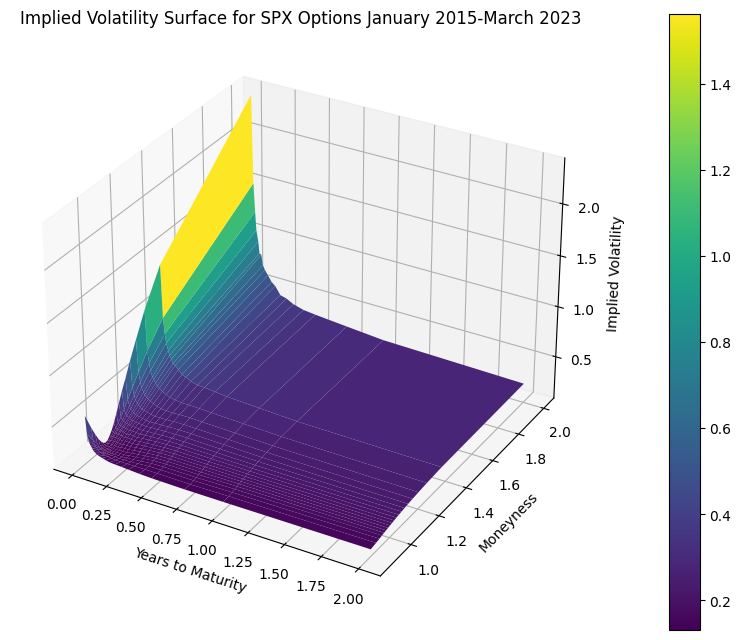

In [ ]:
median_moneyness = df.groupby('moneyness_bucket')['Moneyness'].max().reset_index(name='median_moneyness')
median_ttm = df.groupby('ttm_bucket')['TTM'].max().reset_index(name='median_ttm')
grouped_data = grouped_data.merge(median_moneyness, on='moneyness_bucket')
grouped_data = grouped_data.merge(median_ttm, on='ttm_bucket')
pivot_table = grouped_data.pivot_table(values='implied_vol_t-1', index='median_moneyness', columns='median_ttm')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_vals, y_vals = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)
surface = ax.plot_surface(x_vals, y_vals, pivot_table.values, cmap='viridis')

# Add title
ax.set_title('Implied Volatility Surface for SPX Options January 2015-March 2023')

ax.set_xlabel('Years to Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surface, ax=ax, pad=0.1)

plt.show()